# Forecasting using ARIMA type methods 
* Guides with codes on https://ranasinghiitkgp.medium.com/time-series-forecasting-using-lstm-arima-moving-average-use-case-single-multi-variate-with-code-5dd41e32d1fc
* Here we try out and compare different forecasting methods:
  * Linear regression
  * K-nearest neighbours
  * ARIMA
    * Vanilla
    * Models from Olga's codes:
        * ARIMA with exogenous vars 
        * Vanill recursive ARIMA 
        * Recursive ARIMA with exogenous vars 
  * LSTM (long short term memory)
* We use data from 2019-Q1 to 2021-Q3
    * Compute the RMSE for each model on 2021-Q4 data (leave-the-latest-out validationn)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# install and import necessary packages 

!pip install geopandas rtree &> /dev/null 

import geopandas as gpd
import pandas as pd
import numpy as np
import rtree
import os
import pickle
import matplotlib.pyplot as plt

print(os.getcwd())

Mounted at /content/drive
/content


In [4]:
## Load the source data
os.chdir('/content/drive/MyDrive/shared/ssc22-case-comp/')

with open('./dataset/can-speed-tiles-with-dist37.p', 'rb') as file:
    can_data = pickle.load(file)

can_data.head(5)


,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,year,quarter,conn_type,PRUID,...,DAUID,SACTYPE,DA_POP,PCUID,PCNAME,PCTYPE,PCCLASS,geometry,centroid,distance
0,23331133131332,11910,1408,27,1,1,2019,Q1,fixed,61,...,61010033,8,590.0,NaN,NaN,NaN,NaN,"POLYGON ((4593360.869 4089469.904, 4593533.055...",POINT (4593377.649610395 4089314.513268585),53.062368
1,23331133133011,14969,1554,25,1,1,2019,Q1,fixed,61,...,61010033,8,590.0,NaN,NaN,NaN,NaN,"POLYGON ((4592705.709 4089714.238, 4592877.874...",POINT (4592722.450906813 4089558.8293624604),53.761584
2,32202103303220,5038,1317,54,1,1,2019,Q1,fixed,61,...,61010054,8,330.0,NaN,NaN,NaN,NaN,"POLYGON ((4736491.486 4146142.702, 4736658.777...",POINT (4736511.988045422 4145995.9290841497),120.234330
3,32220031120102,13419,6169,50,4,1,2019,Q1,fixed,61,...,61010045,8,275.0,NaN,NaN,NaN,NaN,"POLYGON ((4642710.684 4070147.116, 4642884.538...",POINT (4642730.427346777 4069993.021852067),0.219597
4,32220031120103,13587,1095,28,2,1,2019,Q1,fixed,61,...,61010045,8,275.0,388.0,Inuvik,4.0,2.0,"POLYGON ((4642884.538 4070012.633, 4643058.404...",POINT (4642904.29490283 4069858.5401834683),0.000000


In [5]:
import sys
sys.path.append(os.path.abspath("/content/drive/MyDrive/shared/ssc22-case-comp/sonny_dir/custom_modules"))
from importlib import reload
import weighted_average_ver3 as WA

rural_data = can_data[pd.isnull(can_data['PCUID'])]  ## select rural (PCUID==nan) tiles only
rural_data.head(5)

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,year,quarter,conn_type,PRUID,...,DAUID,SACTYPE,DA_POP,PCUID,PCNAME,PCTYPE,PCCLASS,geometry,centroid,distance
0,23331133131332,11910,1408,27,1,1,2019,Q1,fixed,61,...,61010033,8,590.0,NaN,NaN,NaN,NaN,"POLYGON ((4593360.869 4089469.904, 4593533.055...",POINT (4593377.649610395 4089314.513268585),53.062368
1,23331133133011,14969,1554,25,1,1,2019,Q1,fixed,61,...,61010033,8,590.0,NaN,NaN,NaN,NaN,"POLYGON ((4592705.709 4089714.238, 4592877.874...",POINT (4592722.450906813 4089558.8293624604),53.761584
2,32202103303220,5038,1317,54,1,1,2019,Q1,fixed,61,...,61010054,8,330.0,NaN,NaN,NaN,NaN,"POLYGON ((4736491.486 4146142.702, 4736658.777...",POINT (4736511.988045422 4145995.9290841497),120.234330
3,32220031120102,13419,6169,50,4,1,2019,Q1,fixed,61,...,61010045,8,275.0,NaN,NaN,NaN,NaN,"POLYGON ((4642710.684 4070147.116, 4642884.538...",POINT (4642730.427346777 4069993.021852067),0.219597
9,32220031121023,4719,751,53,1,1,2019,Q1,fixed,61,...,61010050,8,530.0,NaN,NaN,NaN,NaN,"POLYGON ((4643311.463 4069127.325, 4643485.405...",POINT (4643331.276022766 4068973.2125450033),0.219634


In [7]:
rural_data.info()
rural_data['SACTYPE'].unique()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1498904 entries, 0 to 2751463
Data columns (total 23 columns):
 #   Column      Non-Null Count    Dtype   
---  ------      --------------    -----   
 0   quadkey     1498904 non-null  int64   
 1   avg_d_kbps  1498904 non-null  int64   
 2   avg_u_kbps  1498904 non-null  int64   
 3   avg_lat_ms  1498904 non-null  int64   
 4   tests       1498904 non-null  int64   
 5   devices     1498904 non-null  int64   
 6   year        1498904 non-null  int64   
 7   quarter     1498904 non-null  object  
 8   conn_type   1498904 non-null  object  
 9   PRUID       1498904 non-null  int64   
 10  PRNAME      1498904 non-null  object  
 11  CDUID       1498904 non-null  int64   
 12  CDNAME      1498904 non-null  object  
 13  DAUID       1498904 non-null  int64   
 14  SACTYPE     1498904 non-null  int64   
 15  DA_POP      1487765 non-null  float64 
 16  PCUID       0 non-null        float64 
 17  PCNAME      0 non-null        object  

array([8, 3, 6, 7, 5, 4, 2, 1])

In [12]:
data = WA.w_avg2(rural_data, group_col='CDUID', to_avg=['avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'SACTYPE', 'distance'], to_w_sum = ['DA_POP'], to_sum=['devices'], weight='tests')
data

,CDUID,conn_type,time,avg_d_kbps,avg_u_kbps,avg_lat_ms,SACTYPE,distance,DA_POP,devices,tests
0,6101,fixed,2019-Q1,9831.400000,2016.100000,31.800000,8.0,10.495059,486.000000,7,30
1,6101,fixed,2019-Q2,13634.333333,12547.166667,32.625000,8.0,9.698615,470.833333,14,24
2,6101,fixed,2019-Q3,11597.645161,5392.903226,35.677419,8.0,23.834000,521.370968,24,62
3,6101,fixed,2019-Q4,19082.222222,6148.518519,35.851852,8.0,28.958923,520.370370,11,27
4,6101,fixed,2020-Q1,13727.400000,2896.050000,41.700000,8.0,21.262390,540.250000,12,20
...,...,...,...,...,...,...,...,...,...,...,...
6936,6204,mobile,2021-Q2,23405.000000,2527.617647,23.823529,8.0,0.270435,2370.441176,4,34
6937,6204,mobile,2021-Q3,154825.000000,15989.000000,15.000000,8.0,0.262470,2320.000000,1,6
6938,6204,mobile,2021-Q4,85233.333333,19181.833333,15.000000,8.0,0.262523,2450.000000,3,6
6939,6208,fixed,2020-Q2,3920.000000,9202.000000,5.000000,8.0,432.761001,1.000000,1,1


In [13]:
with open('./sonny_dir/cd-w-avg-dist-rural.p', 'wb') as file:
    pickle.dump(data, file)

In [22]:
data['avg_d_mbps'] = data['avg_d_kbps']/1000

In [43]:
# create a subset of data for avg_d_mbps
d_data = data[['CDUID', 'avg_d_mbps', 'distance', 'DA_POP', 'SACTYPE', 'devices', 'tests', 'conn_type', 'time']]

## convert time (year-quarter) to datetime format (year-month)
from datetime import datetime 

years = list(range(2019, 2022))
months = ['03-31', '06-30', '09-30', '12-31']
year_months = []
for year in years:
    for month in months:
        year_months.append(str(year) + '-' + month)
year_quarters = sorted(d_data['time'].unique())

d_data['time'] = d_data['time'].replace(dict(zip(year_quarters, year_months)))
d_data['time'] = pd.to_datetime(d_data['time'])
d_data['time'] = pd.to_datetime(d_data['time'], format('%Y-%m'))

## convert CDUID to categorical variable
d_data['CDUID'] = d_data['CDUID'].astype('category')
d_data['conn_type'] = d_data['conn_type'].astype('category')

d_data['devices'] = pd.to_numeric(d_data['devices'])
d_data['tests'] = pd.to_numeric(d_data['tests'])
d_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6941 entries, 0 to 6940
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CDUID       6941 non-null   category      
 1   avg_d_mbps  6941 non-null   float64       
 2   distance    6941 non-null   float64       
 3   DA_POP      6941 non-null   float64       
 4   SACTYPE     6941 non-null   float64       
 5   devices     6941 non-null   int64         
 6   tests       6941 non-null   int64         
 7   conn_type   6941 non-null   category      
 8   time        6941 non-null   datetime64[ns]
dtypes: category(2), datetime64[ns](1), float64(4), int64(2)
memory usage: 410.6 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [24]:
d_data.head(5)

,CDUID,avg_d_mbps,distance,DA_POP,SACTYPE,devices,tests,conn_type,time
0,6101,9.831400,10.495059,486.000000,8.0,7,30,fixed,2019-03-31
1,6101,13.634333,9.698615,470.833333,8.0,14,24,fixed,2019-06-30
2,6101,11.597645,23.834000,521.370968,8.0,24,62,fixed,2019-09-30
3,6101,19.082222,28.958923,520.370370,8.0,11,27,fixed,2019-12-31
4,6101,13.727400,21.262390,540.250000,8.0,12,20,fixed,2020-03-31


In [86]:
## split training set and validation set
val_time = year_months[-1]
train_idx = d_data['time'] != val_time
val_idx = d_data['time'] == val_time
train_set = d_data.loc[train_idx, :]
val_set = d_data.loc[val_idx, :]

# create a subset to store true values and forecasts
f_set = val_set[['CDUID', 'conn_type', 'avg_d_mbps']]
# As we train & make forecasts, create a column for that model and store it.
# for example, 
# f_set['model1'] = preds
# f_set

# create a dataframe to store the errors
mse_df = pd.DataFrame(val_set.loc[:,['CDUID', 'conn_type']])
mse_df

# one-hot encode the categories
data_onehot = pd.get_dummies(data = d_data, columns = ['CDUID', 'conn_type'], drop_first=True) # drop_first gives k-1 dummy variables instead of k

train_x = data_onehot.loc[train_idx, :].drop(columns=['avg_d_mbps'])
train_y = data_onehot.loc[train_idx, 'avg_d_mbps']
val_x = data_onehot.loc[val_idx, :].drop(columns=['avg_d_mbps'])
val_y = data_onehot.loc[val_idx, 'avg_d_mbps']

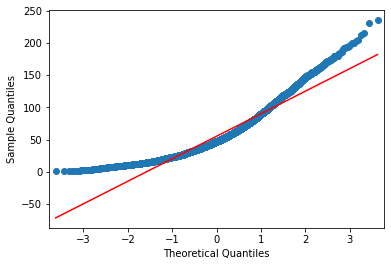

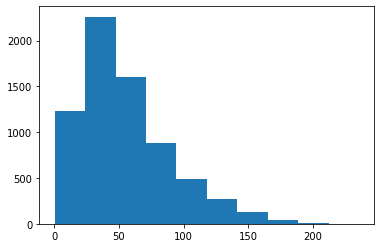

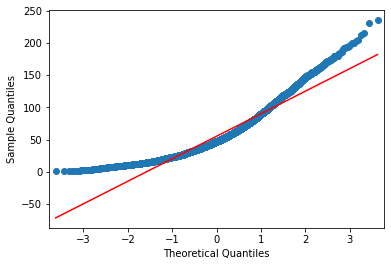

In [90]:
# Check normality
import matplotlib.pyplot as plt
plt.hist(data_onehot['avg_d_mbps'])

from statsmodels.graphics.gofplots import qqplot
qqplot(data_onehot['avg_d_mbps'], line='s')

In [87]:
## Linear regression
import statsmodels.api as sm

### Prepare data
data_lin = data_onehot.copy()

### Make features? (like, make time a numerical variable?)
times = sorted(d_data.loc[:,'time'].unique())
time_ints = [*range(1,len(times)+1)]
data_lin.loc[:,'time_int'] = data_lin.loc[:,'time'].replace(to_replace=times, value = time_ints)

### Split train, val data

data_lin = sm.add_constant(data_lin) # comment this out if constant ignored

lin_train_set = data_lin.loc[train_idx, :]
lin_x_train = lin_train_set.drop(columns=['time', 'avg_d_mbps'])
lin_y_train = lin_train_set['avg_d_mbps']

lin_val_set = data_lin.loc[val_idx, :]
lin_x_valid = lin_val_set.drop(columns=['time', 'avg_d_mbps'])
lin_y_valid = lin_val_set.loc[:,'avg_d_mbps']

### Fit linear regression
OLS_model1 = sm.OLS(lin_y_train, lin_x_train).fit()

### make predictions
lr_preds = OLS_model1.predict(lin_x_valid)

### Compute rmse
from statsmodels.tools.eval_measures import rmse

lr_rmse = rmse(lin_y_valid, lr_preds)

print(lr_rmse)

32.588962482277914


In [91]:
OLS_model1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:                OLS              Adj. R-squared:     0.569     
Dependent Variable:   avg_d_mbps       AIC:                57582.9293
Date:                 2022-04-28 16:33 BIC:                59610.3588
No. Observations:     6362             Log-Likelihood:     -28491.   
Df Model:             299              F-statistic:        29.04     
Df Residuals:         6062             Prob (F-statistic): 0.00      
R-squared:            0.589            Scale:              476.84    
---------------------------------------------------------------------
                  Coef.   Std.Err.    t     P>|t|    [0.025   0.975] 
---------------------------------------------------------------------
const             87.6666   5.9892  14.6375 0.0000   75.9257  99.4075
distance           0.0057   0.0103   0.5558 0.5784   -0.0144   0.0258
DA_POP             0.0040   0.0015   2.6016 0.0093    0.0010   0.0070
SACTYPE           -3.7496   1.0841  -3.4588 0.0005   -5.8747  -1.6244
devices            0.0188   0.0031   6.0746 0.0000    0.0127   0.0248
tests             -0.0045   0.0007  -6.2187 0.0000   -0.0059  -0.0031
CDUID_1002       -11.2772   7.0648  -1.5963 0.1105  -25.1267   2.5723
CDUID_1003       -44.0259   7.1634  -6.1459 0.0000  -58.0687 -29.9830
CDUID_1004       -12.3295   6.9212  -1.7814 0.0749  -25.8975   1.2385
CDUID_1005       -29.0679   6.6575  -4.3662 0.0000  -42.1189 -16.0169
CDUID_1006        -8.9737   6.6199  -1.3556 0.1753  -21.9511   4.0036
CDUID_1007       -13.6573   7.1288  -1.9158 0.0554  -27.6324   0.3178
CDUID_1008       -15.4358   7.0171  -2.1997 0.0279  -29.1917  -1.6798
CDUID_1009       -44.7600   7.2279  -6.1927 0.0000  -58.9293 -30.5908
CDUID_1010       -19.4453   7.3726  -2.6375 0.0084  -33.8981  -4.9925
CDUID_1011       -64.0483   8.9158  -7.1837 0.0000  -81.5264 -46.5703
CDUID_1101       -38.8089   6.8830  -5.6384 0.0000  -52.3020 -25.3158
CDUID_1102       -37.3530   6.6081  -5.6526 0.0000  -50.3071 -24.3988
CDUID_1103       -42.1403   6.7456  -6.2470 0.0000  -55.3642 -28.9165
CDUID_1201       -26.3900   7.3092  -3.6105 0.0003  -40.7186 -12.0614
CDUID_1202       -28.6640   7.3110  -3.9206 0.0001  -42.9962 -14.3318
CDUID_1203       -29.3217   7.3107  -4.0108 0.0001  -43.6533 -14.9901
CDUID_1204       -32.7198   7.3195  -4.4702 0.0000  -47.0686 -18.3710
CDUID_1205       -30.5121   7.0901  -4.3035 0.0000  -44.4112 -16.6130
CDUID_1206       -32.4158   6.8281  -4.7474 0.0000  -45.8014 -19.0302
CDUID_1207       -34.4402   6.6624  -5.1693 0.0000  -47.5009 -21.3795
CDUID_1208       -28.0158   6.6755  -4.1968 0.0000  -41.1022 -14.9294
CDUID_1209        -4.0539   6.9615  -0.5823 0.5604  -17.7009   9.5931
CDUID_1210       -42.8103   6.6039  -6.4826 0.0000  -55.7564 -29.8643
CDUID_1211       -49.5629   6.9699  -7.1110 0.0000  -63.2264 -35.8994
CDUID_1212       -47.1463   6.6145  -7.1277 0.0000  -60.1130 -34.1795
CDUID_1213       -59.9379   7.1420  -8.3923 0.0000  -73.9388 -45.9370
CDUID_1214       -44.9254   7.0817  -6.3439 0.0000  -58.8080 -31.0428
CDUID_1215       -53.2253   7.2025  -7.3898 0.0000  -67.3448 -39.1058
CDUID_1216       -52.5404   7.1025  -7.3975 0.0000  -66.4638 -38.6170
CDUID_1217       -25.8767   6.6013  -3.9200 0.0001  -38.8176 -12.9359
CDUID_1218       -38.5887   7.0321  -5.4875 0.0000  -52.3740 -24.8033
CDUID_1301        -1.4302   6.9746  -0.2051 0.8375  -15.1030  12.2425
CDUID_1302       -42.9604   7.0144  -6.1246 0.0000  -56.7110 -29.2097
CDUID_1303       -14.5462   6.6083  -2.2012 0.0278  -27.5008  -1.5916
CDUID_1304       -51.0856   6.8150  -7.4961 0.0000  -64.4454 -37.7259
CDUID_1305       -31.6506   6.6100  -4.7883 0.0000  -44.6085 -18.6926
CDUID_1306       -47.0899   6.6825  -7.0467 0.0000  -60.1900 -33.9898
CDUID_1307        -1.1663   6.5889  -0.1770 0.8595  -14.0829  11.7503
CDUID_1308       -15.0819   6.7709  -2.2275 0.0260

In [57]:
## k-Nearest Neighbours

from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#scaling data
x_tr_scaled_df = pd.DataFrame(scaler.fit_transform(lin_x_train))
x_val_scaled_df = pd.DataFrame(scaler.fit_transform(lin_x_valid))

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4]}
knn = neighbors.KNeighborsRegressor()
k_model = GridSearchCV(knn, params, cv=4)

#fit the model and make predictions
k_model.fit(x_tr_scaled_df, train_y)
k_preds = k_model.predict(x_val_scaled_df)

f_set['k-nearest'] = k_preds
mse_df['k-nearest'] = k_preds - f_set.loc[:, 'avg_d_mbps']
mse_df
k_rmse = np.sqrt(np.sum(np.square(mse_df.loc[:,'k-nearest']))/len(k_preds))
print(k_rmse)

53.25031375992785


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
## Vanilla ARIMA
!pip install pmdarima &> /dev/null

from pmdarima.arima import auto_arima

## prepare data
ar_train = d_data.loc[train_idx, ['CDUID', 'conn_type', 'avg_d_mbps']]
ar_val = d_data.loc[val_idx, ['avg_d_mbps', 'conn_type']]
ar_val['ARIMA'] = 0

## For auto_arima, we must fit and forecast for each CDUID

ar_preds = pd.DataFrame(data= ar_train[['CDUID', 'conn_type']], columns = ['CDUID', 'conn_type']).drop_duplicates(keep='first')
ar_models = {}

for id in ar_train['CDUID'].unique():
    
    print('processing: {pr}'.format(pr=id))
    # ar_subset = np.array(sorted(ar_train.loc[ar_train['CDUID']== id, 'avg_d_mbps']))
    ar_set = ar_train.loc[ar_train['CDUID']==id, :]
    
    for t in ar_set['conn_type'].unique():
        try:
            ar_subset = np.array(ar_set.loc[ar_set['conn_type']==t, 'avg_d_mbps'])
        except:
            break
        
        if len(ar_subset) > 3:
            ar_model = auto_arima(ar_subset, 
                            start_p=0, 
                            start_q=0,
                            max_p=3, 
                            max_q=3, 
                            start_P=0, 
                            seasonal=False,
                            d=1, 
                            information_criterion = 'bic',
                            D=0, 
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True
                            )
            ar_sub_dict = {t: ar_model} ## store best fit model for each conn_type
            temp_pred = ar_model.predict(n_periods = 1)[0]
        else:
            try:
                temp_pred = ar_subset[-1]
            except:
                print('problem at {pr}'.format(pr=id))
                temp_pred = ar_subset
        ar_models[id] = ar_sub_dict # store best fit models for each CDUID
        print('{pr} and {pred}'.format(pr=id, pred=temp_pred))
        ar_pred_idx = (ar_preds['CDUID']==id) & (ar_preds['conn_type'] == t)
        ar_preds.loc[ar_pred_idx, 'ARIMA'] = temp_pred

print(len(ar_preds))

f_set2 = pd.merge(f_set, ar_preds, how='left', on = ['CDUID', 'conn_type'])

## RMSE of the ARIMA model
ar_rmse = np.sqrt(np.sum(np.square(f_set2.loc[:, 'ARIMA'] - f_set2.loc[:, 'avg_d_mbps'])) / len(f_set2))
print(ar_rmse)

Streaming output truncated to the last 5000 lines.
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=80.213, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=75.707, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : BIC=77.861, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=77.912, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=inf, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : BIC=inf, Time=0.28 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.605 seconds
4620 and 27.080488524093802
processing: 4705
Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=84.366, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=86.368, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=86.393, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=83.664, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=88.667, Time=0.20 sec

Best model:  ARIMA(0,1,0

In [ ]:
## diagnostics
# model.plot_diagnostics(figsize=(7,5))
# plt.show()

In [62]:
## ARIMA with exogenous variables

## exogenous variables: Here, we treat variables other than avg_d_mbps as exogenous variables
ar_exo_vars = ['distance', 'DA_POP', 'SACTYPE', 'devices']

## prepare data
ar_exo_data = d_data[['CDUID','conn_type', 'avg_d_mbps', 'distance', 'DA_POP', 'SACTYPE', 'devices']]

## For auto_arima, we must fit and forecast for each CDUID

ar_exo_preds = pd.DataFrame(data= ar_exo_data[['CDUID', 'conn_type']], columns = ['CDUID', 'conn_type']).drop_duplicates(keep='first')
ar_exo_preds['ARIMA_exo'] = 0
ar_exo_models = {}

ids = ar_exo_data['CDUID'].unique()
ids_new = ids
# ids_new = ids[290:]

for id in ids_new:
    
    print('processing: {pr}'.format(pr=id))
    
    ar_set = ar_exo_data.loc[ar_exo_data['CDUID']==id, ['conn_type', 'avg_d_mbps', 'distance', 'DA_POP', 'SACTYPE', 'devices']]
    
    for t in ar_set['conn_type'].unique():
        try:
            ar_exo_subset = ar_set.loc[ar_set['conn_type']==t, :].reset_index()
            ar_exo_subset_train = ar_exo_subset.iloc[:-1]
            ar_exo_subset_val = ar_exo_subset.iloc[[-1]]
        except:
            print('error!, len={ln}'.format(ln = len(ar_exo_subset)))
            break
        
        if len(ar_exo_subset) > 3:
            ar_exo_model = auto_arima(ar_exo_subset_train.loc[:, 'avg_d_mbps'], 
                            start_p=0, 
                            start_q=0,
                            max_p=3, 
                            max_q=3, 
                            start_P=0, 
                            seasonal=False,
                            d=1, 
                            information_criterion = 'bic',
                            D=0, 
                            exogenous = ar_exo_subset_train.loc[:, ar_exo_vars],
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True
                            )
            ar_exo_sub_dict = {t: ar_exo_model} ## store best fit model for each conn_type
            # ar_exo_val_idx = (ar_exo_subset_val['CDUID'] == id) & (ar_exo_subset_val['conn_type']==t)
            print('{id}, {conn_type}'.format(id=id, conn_type=t))
            temp_pred = ar_exo_model.predict(n_periods = 1, exogenous= ar_exo_subset_val.loc[:, ar_exo_vars])[0]
        
        elif len(ar_exo_subset) == 1:
            temp_pred = ar_exo_subset['avg_d_mbps'][0]
            
        else:   
            try:
                temp_pred = ar_exo_subset_train.loc[:,'avg_d_mbps'].iloc[-1]
            except:
                print('problem at {pr}'.format(pr=id))
                
        ar_exo_models[id] = ar_exo_sub_dict # store best fit models for each CDUID
        print('{pr} and {pred}'.format(pr=id, pred=temp_pred))
        ar_exo_pred_idx = (ar_exo_preds['CDUID']==id) & (ar_exo_preds['conn_type'] == t)
        ar_exo_preds.loc[ar_exo_pred_idx, 'ARIMA_exo'] = temp_pred

print(len(ar_exo_preds))

f_set3 = pd.merge(f_set2, ar_exo_preds, how='left', on = ['CDUID', 'conn_type'])

## RMSE of the ARIMA model
ar_exo_rmse = np.sqrt(np.sum(np.square(f_set3.loc[:, 'ARIMA_exo'] - f_set3.loc[:, 'avg_d_mbps'])) / len(f_set2))
print(ar_exo_rmse)

Streaming output truncated to the last 5000 lines.
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=91.606, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : BIC=94.078, Time=0.52 sec
 ARIMA(2,1,1)(0,0,0)[0]             : BIC=66.990, Time=0.39 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 4.655 seconds
2497, mobile
2497 and 59.25599272497669
processing: 2494
Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=77.868, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=78.016, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=77.225, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=76.408, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=79.300, Time=0.35 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.073 seconds
2494, fixed
2494 and 86.36048625802019
Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BI

In [66]:
## check the models

# ar_models
# ar_exo_models

## save ar_models:

ar_type_models = {'ar': ar_models, 'ar_exo': ar_exo_models}

with open('./sonny_dir/arima_models_cd.p', 'wb') as file:
    pickle.dump(ar_type_models, file)

## save results:
models = ['LR', 'k-nearest', 'ARIMA', 'ARIMA_exo']
rmse = []
for model in models:
    rmse.append(np.sqrt(np.sum(np.square(f_set3.loc[:, model] - f_set3.loc[:, 'avg_d_mbps'])) / len(f_set3)))
rmse_table = pd.DataFrame(np.array([models, rmse]))
rmse_table

E11_results = {'f_set': f_set4, 'rmse':rmse_table, 'ar': ar_models, 'ar_exo': ar_exo_models}
with open('./output-data/E11-results-rural.p', 'wb') as file:
    pickle.dump(E11_results, file)

In [67]:
from sklearn.ensemble import RandomForestRegressor

# lin_x_train = lin_train_set.drop(columns=['avg_d_mbps'])
# lin_y_train = lin_train_set[['avg_d_mbps']]

regressor = RandomForestRegressor(n_estimators=20, 
                                  random_state=0,
                                  oob_score=True)
regressor.fit(lin_x_train, lin_y_train)
y_pred = regressor.predict(lin_x_valid)
y_pred
RF_oob_score = regressor.oob_score_
RF_rmse = np.sqrt(np.sum(np.square(y_pred - f_set['avg_d_mbps'])) / len(f_set))
print(RF_oob_score)
print(RF_rmse)

0.585507735976917
26.61412903302688


In [68]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=100, 
                                 learning_rate=0.1,
                                 random_state=0).fit(lin_x_train, lin_y_train)
gbr_pred = gbr.predict(lin_x_valid)
print(gbr.score(lin_x_valid, lin_y_valid))
gbr_rmse = np.sqrt(np.sum(np.square(gbr_pred - f_set['avg_d_mbps']))/len(f_set) )
print(gbr_rmse)

0.3877680921622825
33.6220084724506


In [69]:
import lightgbm as ltb

ltb_reg = ltb.LGBMRegressor(n_estimators=100, 
                            learning_rate=0.1,
                            random_state=0
                            ).fit(lin_x_train, lin_y_train)
ltb_pred = ltb_reg.predict(lin_x_valid)
# print(ltb_reg.score(lin_x_valid, lin_y_valid))
ltb_rmse = np.sqrt(np.sum(np.square(ltb_pred - f_set['avg_d_mbps']))/len(f_set) )
print(ltb_rmse)

28.182835715192606


In [ ]:
## Recursive ARIMA with exogenous variables



In [ ]:
## Can we use random forests (or GB)?
## We can compute feature importance 

## we can use the same dataset as in the linear regression.

In [ ]:
## perform regression for each SACTYPE?

## Comparison between different SACTYPE can be done by their coefficients for the variables.

## eg. Tiles that are SACTYPE == 8 are impacted less by DA_POP, time than SACTYPE == 1 etc...

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


avg_d_mbps    58.586417
dtype: float64
    avg_d_mbps  tests devices       time  time_int        pred
77  202.881035  88909   27287 2021-06-30        10  150.655090
78  211.508482  93164   30422 2021-09-30        11  151.714752
79  215.701498  90762   29765 2021-12-31        12  152.501297


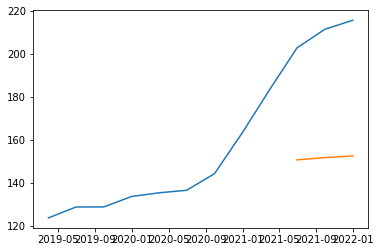

In [ ]:
## Long short term memory

# LSTM has three gates:
# The input gate: The input gate adds information to the cell state
# The forget gate: It removes the information that is no longer required by the model
# The output gate: Output Gate at LSTM selects the information to be shown as output

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

ex2 = example_data.copy()
ex2.index = ex2.time
ex2.drop('time', axis=1, inplace=True)
train = ex2[:-3]
valid = ex2[-3:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ex2)

x_train, y_train = [], []

for i in range(3,len(train)):
    x_train.append(scaled_data[i-3:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=3, 
               return_sequences=True, 
               input_shape=(x_train.shape[1],1))
)
model.add(LSTM(units=3))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=50, batch_size=1, verbose=0)

#predicting 3 values, using past 3 from the train data
inputs = ex2[len(ex2) - len(valid) - 3:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(3,inputs.shape[0]):
    X_test.append(inputs[i-3:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
pred_mod = model.predict(X_test)
pred = scaler.inverse_transform(pred_mod)

rms=np.sqrt(np.mean(np.power((valid-pred),2)))
print(rms)

pred_df = val_set.copy()
pred_df['pred'] = pred
print(pred_df)

plt.plot(plot_x, plot_y)
plt.plot(pred_df['time'], pred_df['pred'])

# does not perform well: may be due to limited data size.

In [ ]:
def prophet():
    ## Facebook's Prophet 
    ## Desigend for daily data --> not appropriate for our csae

    # from fbprophet import Prophet
    ## The input for Prophet is a dataframe with two columns: date and target (ds and y).
    ## Prophet tries to capture the seasonality in the past data and works well when the dataset is large.

    # #preparing data

    # ph_data = d_data[['CDUID','conn_type', 'time', 'avg_d_mbps']].rename(columns={'time': 'ds', 'avg_d_mbps':'y'})

    # ph_preds = pd.DataFrame(data= ar_train[['CDUID', 'conn_type']], columns = ['CDUID', 'conn_type']).drop_duplicates(keep='first')
    # ph_preds['prophet'] = 0

    # prs = ph_data['CDUID'].unique()
    # for pr in prs:
    #     ph_set = ph_data.loc[ph_data['CDUID']==pr, :]
    #     tp_set = ph_set['conn_type'].unique()
    #     for tp in tp_set:
    #         ph_subset = ph_set.loc[ph_set['conn_type'] == tp, ['ds', 'y']]
    #         # ph_subset.index = ph_subset['ds']
    #         try:
    #             ph_train = ph_subset.loc[ph_subset['ds']!= val_time, :]
    #             ph_val = ph_subset.loc[ph_subset['ds']== val_time, :]

    #             ph_model = Prophet()
    #             ph_model.fit(ph_train)

    #             ph_pred = ph_model.make_future_dataframe(periods = len(ph_val))
    #         except:
    #             ph_pred = np.array(ph_subset.loc[:, 'y'])[-1]

    #         ph_pred_idx = (ph_preds['CDUID']==pr) & (ph_preds['conn_type'] == tp)
    #         ph_preds.loc[ph_pred_idx, 'prophet'] = ph_pred


    # f_set3 = pd.merge(f_set2, ph_preds, how='left', on = ['CDUID', 'conn_type'])

    # ## RMSE of the ARIMA model
    # ph_rmse = np.sqrt(np.sum(np.square(f_set3.loc[:, 'prophet'] - f_set3.loc[:, 'avg_d_mbps'])) / len(f_set3))
    # ph_rmse

    return NA